In [1]:
#!/usr/bin/env python
# coding: utf-8

# Load packages

In [2]:
from IPython import get_ipython

In [3]:
if get_ipython():
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import scanpy as sc
import latenta as la
import jax
import jax.numpy as jnp
import optax
import tqdm.auto as tqdm
import scipy
import random
import re
import dill as pickle
import sklearn.decomposition
import os
import eyck
from general_functions.model_generation_functions import *
from general_functions.model_visualization_functions import *

/srv/data/robinve/miniconda3/envs/latenta/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## unpack the data

In[12]:

To load the pickled AnnData object back into memory

In [4]:
with open("../../real_data/wild_type_cells.pkl", "rb") as f:
    adata = pickle.load(f)

In [5]:
base_model = create_base_model(adata, definition_type=object)

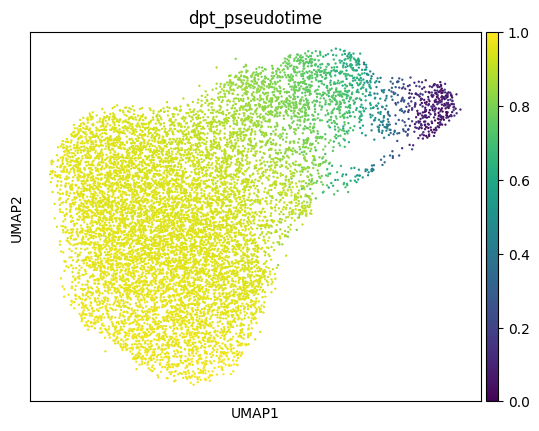

In [6]:
# Identify root and endpoint cell clusters (manually from the PAGA plot)
root_cluster = '5'  # Example cluster ID for the root
end_cluster = '0'  # Example cluster ID for the endpoint

# Select a representative cell from each cluster
root_cell = adata.obs[adata.obs['leiden'] == root_cluster].index[0]
end_cell = adata.obs[adata.obs['leiden'] == end_cluster].index[0]

# Set the root and endpoint cells
adata.uns['iroot'] = adata.obs_names.get_loc(root_cell)
adata.uns['iend'] = adata.obs_names.get_loc(end_cell)
# Compute pseudotime with DPT
sc.tl.dpt(adata, n_dcs=5)


sc.pl.umap(adata, color=["dpt_pseudotime"])

In [7]:
def map_nested_fn(fn):
    """Recursively apply `fn` to key-value pairs of a nested dict."""
    def map_fn(nested_dict):
        return {k: (map_fn(v) if isinstance(v, dict) else fn(k, v)) for k, v in nested_dict.items()}
    return map_fn

In [8]:
@map_nested_fn
def label_fn(k, v):
    # print(k)
    if ("kernel" in k) or ("bias" in k):
        return "a"
    else:
        return "b"

In [9]:
optimizer = optax.multi_transform({"b": optax.adam(5e-3), "a": optax.adam(1e-4)}, label_fn)

In [10]:
adata.X = adata.X.toarray()
adata.X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.7578579 ],
       [0.        , 0.        , 0.28291035, ..., 0.        , 0.        ,
        0.6835809 ],
       [0.        , 0.        , 0.6585069 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.67586887, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [11]:
pca,cells,X =adata_pca(adata)
x = latent_x(pca,cells,X)
initialization_func1 = lambda: unbiased_initialization(x)
initialization_func1.__name__ = 'unbiased_initialization'
x_bias_loc_list = pre_caluclate_pca_biases(pca,cells,X)
placeholder = [0]
initialization_func2 = lambda: semi_biased_initialization(x,x_bias_loc_list, placeholder[0])
initialization_func2.__name__ = 'semi_biased_initialization'
initialization_funcs = [initialization_func1, initialization_func2]

In [12]:
initialization_funcs = [initialization_func1]

In [13]:
np.random.seed(42)

## First base model

In [14]:
n_model_repeats = 1
scores = pd.DataFrame()
model_dict = {}
for j in range(n_model_repeats):
    new_scores, new_model_dict = latenta_processes_basic(base_model, optimizer, "base_model", f"base_model_0_{j}", 1000)
    scores = pd.concat([scores, new_scores], axis=0, ignore_index=True)
    model_dict.update(new_model_dict)
    print(j)

100%|██████████| 1000/1000 [00:43<00:00, 23.21it/s]


0


### generate models

In [16]:
effects=["Linear", "Spline", "CircularSpline", "Sigmoid"]

In [17]:
from itertools import combinations

# Define the list of effects
effects = ["Linear", "Spline", "CircularSpline", "Sigmoid"]

# Generate all combinations of 1 to n elements (where n is the length of the list)
all_combinations = []
for r in range(1, len(effects) + 1):
    all_combinations.extend(combinations(effects, r))

# Convert combinations to a list of lists for better readability
all_combinations = [list(comb) for comb in all_combinations]

In [ ]:
scores = pd.DataFrame()
model_dict = {}
for effects in all_combinations:
    for effect in effects:
        for j in range(10):
            model = change_model_amortized_tuple(base_model.clone(), [effect],initialization_func1, placeholder)
            architecture_name = get_architecture_name(model)

            new_scores, new_model_dict = latenta_processes_basic(model, optimizer, architecture_name, architecture_name+f"_0_{j}", 1)

            scores = pd.concat([scores, new_scores], axis=0, ignore_index=True)
            model_dict.update(new_model_dict)
            safe_pickle(model_dict, "model_dict.pkl", "Initial_exploration_1000epochs")
            safe_pickle(scores, "scores.pkl", "Initial_exploration_1000epochs")

In [ ]:
effects = ["Spline"]
scores = pd.DataFrame()
model_dict = {}
for effect in effects:
    for j in range(10):
        model = change_model_amortized_tuple(base_model.clone(), [effect],initialization_func1, placeholder)
        architecture_name = get_architecture_name(model)

        new_scores, new_model_dict = latenta_processes_basic(model, optimizer, architecture_name, architecture_name+f"_0_{j}", 3000)

        scores = pd.concat([scores, new_scores], axis=0, ignore_index=True)
        model_dict.update(new_model_dict)
        print(j)
        safe_pickle(model_dict, "model_dict.pkl", "Initial_exploration_Spline")
        safe_pickle(scores, "scores.pkl", "Initial_exploration_Spline")

In [ ]:
effects = ["Linear"]
scores = pd.DataFrame()
model_dict = {}
for effect in effects:
    for j in range(10):
        model = change_model_amortized_tuple(base_model.clone(), [effect],initialization_func1, placeholder)
        architecture_name = get_architecture_name(model)

        new_scores, new_model_dict = latenta_processes_basic(model, optimizer, architecture_name, architecture_name+f"_0_{j}", 3000)

        scores = pd.concat([scores, new_scores], axis=0, ignore_index=True)
        model_dict.update(new_model_dict)
        print(j)
        safe_pickle(model_dict, "model_dict.pkl", "Initial_exploration_Linear")
        safe_pickle(scores, "scores.pkl", "Initial_exploration_Linear")

100%|██████████| 3000/3000 [01:53<00:00, 26.35it/s]


0


100%|██████████| 3000/3000 [01:52<00:00, 26.55it/s]


1


100%|██████████| 3000/3000 [01:52<00:00, 26.65it/s]


2


100%|██████████| 3000/3000 [01:52<00:00, 26.65it/s]


3


100%|██████████| 3000/3000 [01:52<00:00, 26.69it/s]


4


100%|██████████| 3000/3000 [01:53<00:00, 26.49it/s]


5


100%|██████████| 3000/3000 [01:52<00:00, 26.62it/s]


6


100%|██████████| 3000/3000 [01:52<00:00, 26.61it/s]


7


100%|██████████| 3000/3000 [01:52<00:00, 26.68it/s]


8


100%|██████████| 3000/3000 [01:52<00:00, 26.67it/s]


9


In [ ]:
effects = ["Linear", "Spline", "Sigmoid"]
scores = pd.DataFrame()
model_dict = {}
for j in range(10):
    model = change_model_amortized_tuple(base_model.clone(), effects,initialization_func1, placeholder)
    architecture_name = get_architecture_name(model)

    new_scores, new_model_dict = latenta_processes_basic(model, optimizer, architecture_name, architecture_name+f"_0_{j}", 3000)

    scores = pd.concat([scores, new_scores], axis=0, ignore_index=True)
    model_dict.update(new_model_dict)
    print(j)
    safe_pickle(model_dict, "model_dict.pkl", "Initial_exploration_Linear_Spline_Sigmoid")
    safe_pickle(scores, "scores.pkl", "Initial_exploration_Linear_Spline_Sigmoid")

100%|██████████| 3000/3000 [02:35<00:00, 19.33it/s]


0


100%|██████████| 3000/3000 [02:33<00:00, 19.53it/s]


1


100%|██████████| 3000/3000 [02:32<00:00, 19.61it/s]


2


100%|██████████| 3000/3000 [02:33<00:00, 19.55it/s]


3


100%|██████████| 3000/3000 [02:33<00:00, 19.59it/s]


4


100%|██████████| 3000/3000 [02:33<00:00, 19.54it/s]


5


100%|██████████| 3000/3000 [02:33<00:00, 19.59it/s]


6


100%|██████████| 3000/3000 [02:33<00:00, 19.54it/s]


7


100%|██████████| 3000/3000 [02:33<00:00, 19.58it/s]


8


100%|██████████| 3000/3000 [02:33<00:00, 19.59it/s]


9


### visualize models

In [ ]:
with open("Initial_exploration_1000epochs/scores.pkl", "rb") as f:
    scores = pickle.load(f)

/tmp/ipykernel_4137136/975812848.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="architecture")


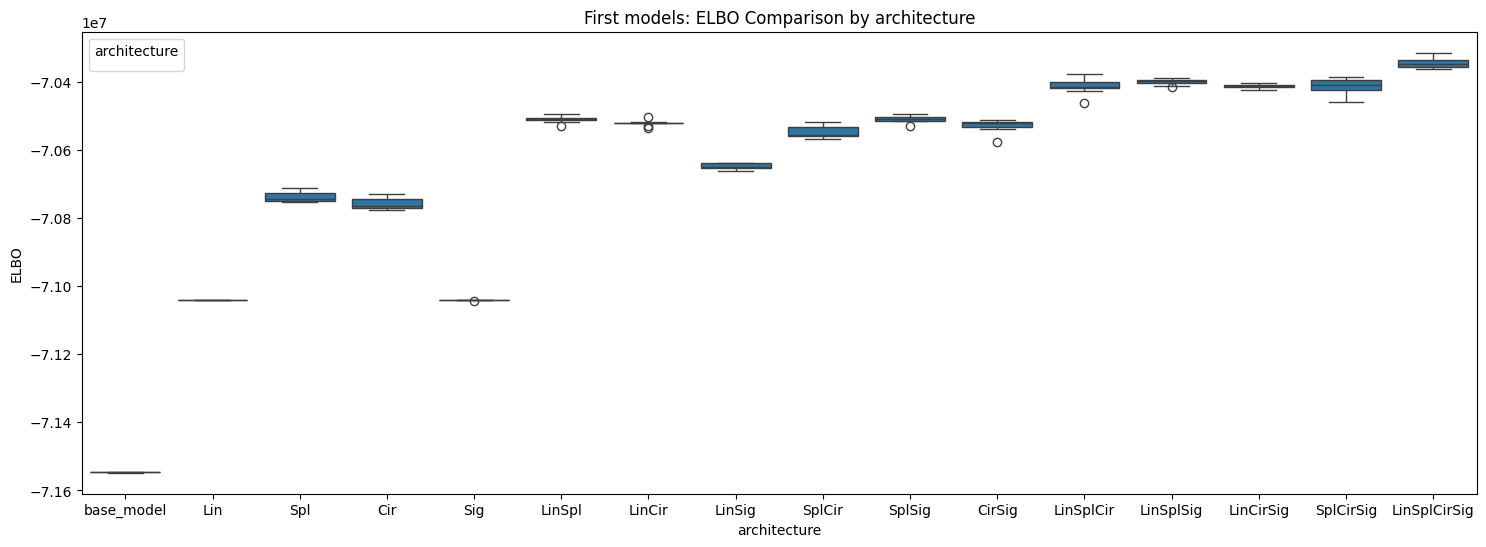

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the color palette
#palette = {"unbiased_initialization": "blue", "semi_biased_initialization": "orange", "biased_initialization":"red"}

# Create the boxplot
plt.figure(figsize=(18, 6))
sns.boxplot(
    x="architecture", 
    y="elbo",
    data=scores, 
)

# Add titles and labels
plt.title("First models: ELBO Comparison by architecture")
plt.xlabel("architecture")
plt.ylabel("ELBO")
plt.legend(title="architecture")
plt.show()


In [ ]:
def count_effects(architecture):
    if architecture == "base_model":
        return 0  # Base model always has 3 effects
    return len(architecture) // 3  # Each effect is 3 letters

# Apply the function to create the new column
scores["number_of_effects"] = scores["architecture"].apply(count_effects)

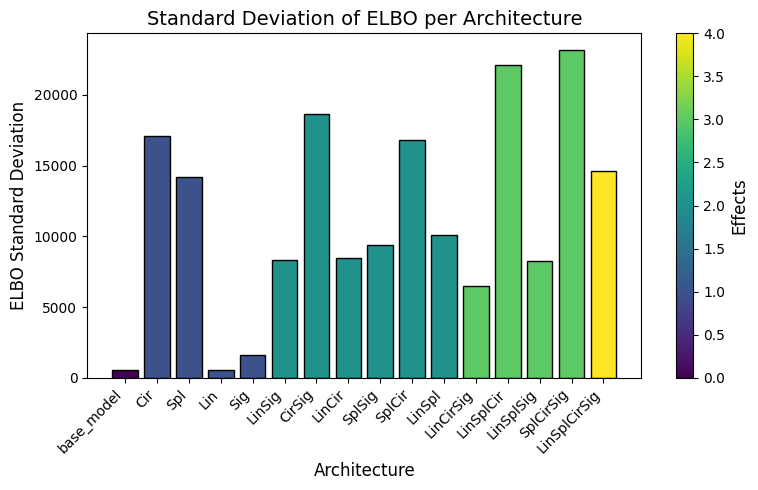

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Calculate standard deviation of ELBO per architecture
elbo_std_per_architecture = scores.groupby('architecture')['elbo'].std().reset_index()
elbo_std_per_architecture["number_of_effects"] = elbo_std_per_architecture["architecture"].apply(count_effects)

# Ensure the DataFrame is sorted by 'number_of_effects'
elbo_std_per_architecture = elbo_std_per_architecture.sort_values(by='number_of_effects')

# Extract the number of effects for color mapping
cmap = plt.cm.viridis  # Choose a colormap
norm = mcolors.Normalize(vmin=elbo_std_per_architecture['number_of_effects'].min(),
                          vmax=elbo_std_per_architecture['number_of_effects'].max())

# Map colors directly from the number_of_effects column
colors = cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba(elbo_std_per_architecture['number_of_effects'])

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(
    elbo_std_per_architecture['architecture'], 
    elbo_std_per_architecture['elbo'], 
    color=colors, 
    edgecolor='black'
)

# Add a colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for ScalarMappable to work with colorbar
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Effects', fontsize=12)

# Add labels and title
ax.set_title('Standard Deviation of ELBO per Architecture', fontsize=14)
ax.set_xlabel('Architecture', fontsize=12)
ax.set_ylabel('ELBO Standard Deviation', fontsize=12)

# Rotate x-axis labels if needed
plt.xticks(rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_multiple_losses_with_completion(loss_list,loss_names=None, tail_size=50, window_size=10):
    """
    Plots the loss values and completion percentages for multiple loss objects with an extra y-axis for percentages.

    Parameters:
    - loss_list: List of loss objects (each can be a DataFrame or Series).
    - tail_size: Number of last values to zoom in on for the second plot.
    - window_size: Size of the rolling window for smoothing the completion percentage.
    """
    colors = plt.cm.tab10.colors  # Use a colormap for distinct colors
    num_losses = len(loss_list)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Secondary y-axis handles for each subplot
    ax1_secondary = axes[0].twinx()
    ax2_secondary = axes[1].twinx()

    for idx, loss_obj in enumerate(loss_list):
        # Convert DataFrame row to Series if necessary
        if isinstance(loss_obj, pd.DataFrame):
            losses = pd.Series(loss_obj.iloc[0])  # Assume first row
        elif isinstance(loss_obj, pd.Series):
            losses = loss_obj
        else:
            raise ValueError(f"Unsupported loss type: {type(loss_obj)}")

        if loss_names:

            loss_label = loss_names[idx]
            completion_label = f'{loss_names[idx]}%'
        else:
            loss_label = f'Loss {idx + 1}'
            completion_label = f'{idx + 1}%'
        # Calculate initial and minimal loss
        initial_loss = losses.iloc[0]
        min_loss = losses.min()

        # Calculate completion percentage
        completion_percentage = ((initial_loss - losses) / (initial_loss - min_loss)) * 100
        smoothed_completion = completion_percentage.rolling(window=window_size).mean()

        # Plot all losses and completion on the first subplot
        axes[0].plot(losses, label=loss_label, color=colors[idx % len(colors)], alpha=0.7)
        ax1_secondary.plot(smoothed_completion, linestyle='dotted', label=completion_label, color=colors[idx % len(colors)])

        # Plot the tail for both losses and completion on the second subplot
        tail_losses = losses.tail(tail_size)
        smoothed_tail_completion = smoothed_completion.tail(tail_size)

        axes[1].plot(tail_losses.index, tail_losses, label=loss_label, color=colors[idx % len(colors)], alpha=0.7)
        ax2_secondary.plot(smoothed_tail_completion.index, smoothed_tail_completion, linestyle='dotted', label=completion_label, color=colors[idx % len(colors)])

    # Finalize the left plot
    axes[0].set_title('All Loss Values')
    axes[0].set_xlabel('Step')
    axes[0].set_ylabel('Loss')
    axes[0].grid()
    axes[0].legend(loc="upper left", bbox_to_anchor=(0.8, 0.65))
    ax1_secondary.set_ylabel('Completion Percentage')
    ax1_secondary.legend(loc="upper left", bbox_to_anchor=(0.8, 0.45))

    # Finalize the right plot
    axes[1].set_title(f'Last {tail_size} Loss Values')
    axes[1].set_xlabel('Step')
    axes[1].set_ylabel('Loss')
    axes[1].grid()
    axes[1].legend(loc="upper left", bbox_to_anchor=(0.8, 0.65))
    ax2_secondary.set_ylabel('Completion Percentage')
    ax2_secondary.legend(loc="upper left", bbox_to_anchor=(0.8, 0.45))

    plt.tight_layout()
    plt.show()

In [ ]:
with open("Initial_exploration_Spline/scores.pkl", "rb") as f:
    scores1 = pickle.load(f)
with open("Initial_exploration_Linear/scores.pkl", "rb") as f:
    scores2 = pickle.load(f)
with open("Initial_exploration_Linear_Spline_Sigmoid/scores.pkl", "rb") as f:
    scores3 = pickle.load(f)

scores = pd.concat([scores1, scores2, scores3], axis=0, ignore_index=True)


In [ ]:
scores_spl = scores[scores["architecture"] == "Spl"]
scores_lin = scores[scores["architecture"] == "Lin"]
scores_lin = scores_lin.reset_index()
scores_LinSplSig = scores[scores["architecture"] == "LinSplSig"]
scores_LinSplSig = scores_LinSplSig.reset_index()
model_name_best_spl = scores_spl.iloc[scores_spl["elbo"].idxmax()]["model_name"]
model_name_worst_spl = scores_spl.iloc[scores_spl["elbo"].idxmin()]["model_name"]

model_name_best_lin = scores_lin.iloc[scores_lin["elbo"].idxmax()]["model_name"]
model_name_worst_lin = scores_lin.iloc[scores_lin["elbo"].idxmin()]["model_name"]

model_name_best_linSplSig = scores_LinSplSig.iloc[scores_LinSplSig["elbo"].idxmax()]["model_name"]
model_name_worst_linSplSig = scores_LinSplSig.iloc[scores_LinSplSig["elbo"].idxmin()]["model_name"]
best_spl_model_losses = model_dict[model_name_best_spl][1]
worst_spl_model_losses = model_dict[model_name_worst_spl][1]

best_lin_model_losses = model_dict[model_name_best_lin][1]
worst_lin_model_losses = model_dict[model_name_worst_lin][1]

best_linSplSig_model_losses = model_dict[model_name_best_linSplSig][1]
worst_linSplSig_model_losses = model_dict[model_name_worst_linSplSig][1]
all_losses = [best_spl_model_losses,worst_spl_model_losses,best_lin_model_losses,worst_lin_model_losses,best_linSplSig_model_losses,worst_linSplSig_model_losses]
loss_names = ['b_spl','w_spl','b_lin','w_lin','b_linSplSig','w_linSplSig']

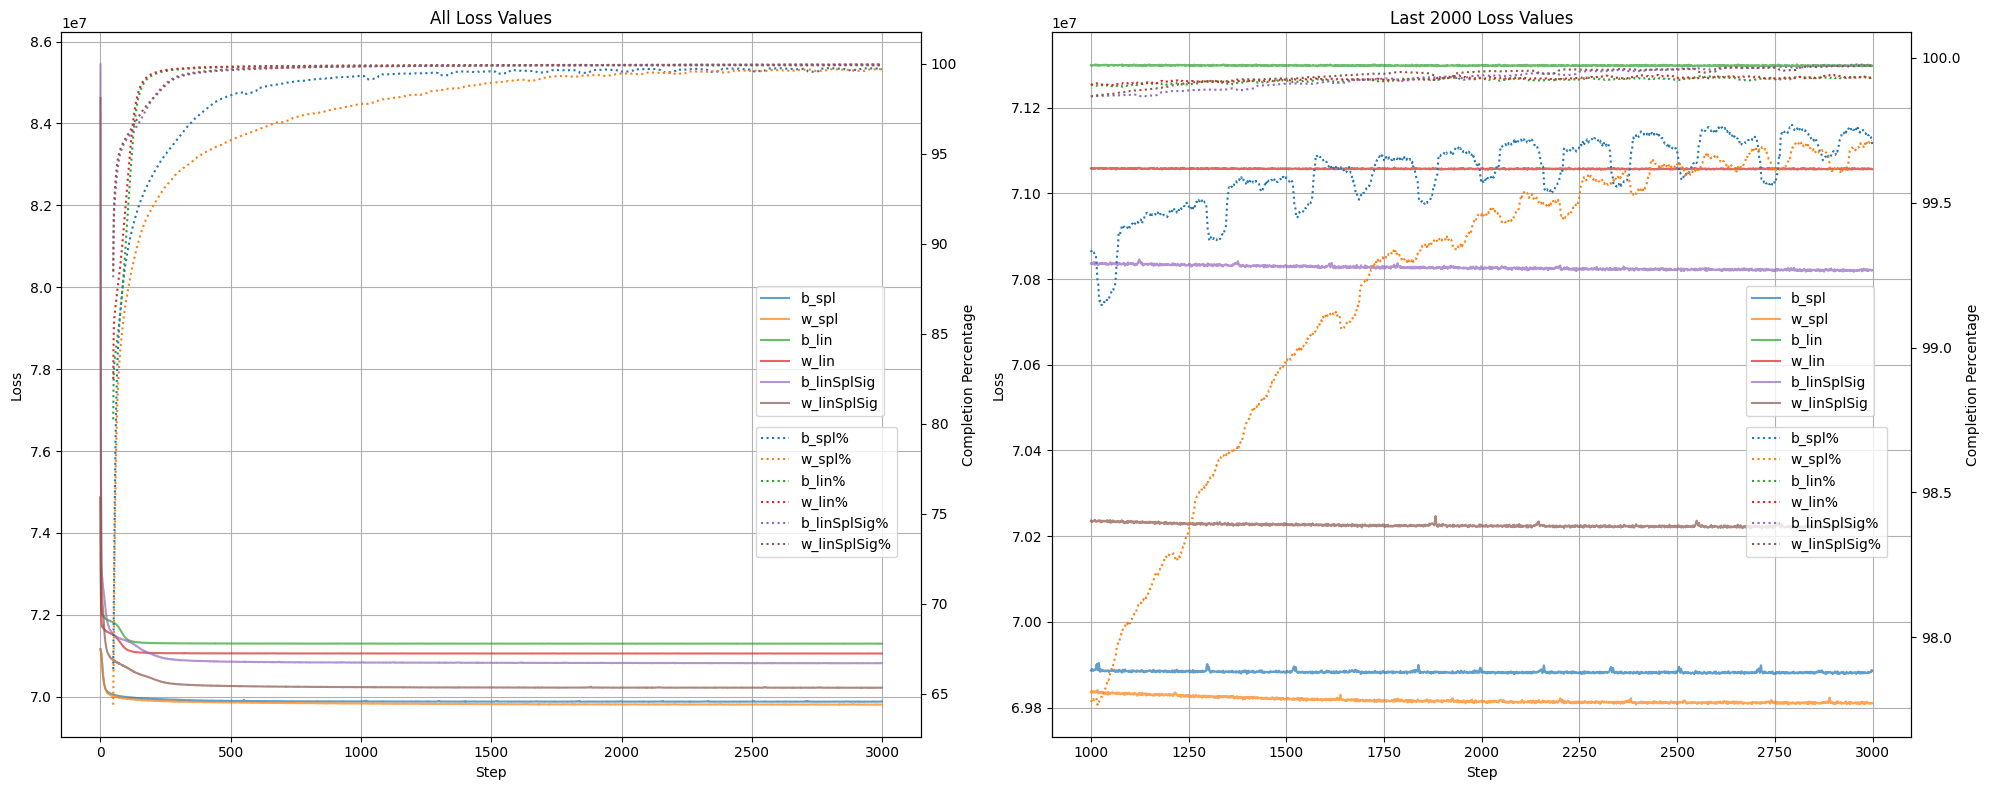

In [ ]:

# Call the function with a list of loss objects
plot_multiple_losses_with_completion(all_losses,loss_names=loss_names, tail_size=2000, window_size=50)